<a href="https://colab.research.google.com/github/tdushio/shiolabOpen/blob/master/32_Demo_LQR%E3%81%AB%E3%82%88%E3%82%8B%E5%80%92%E7%AB%8B%E6%8C%AF%E5%AD%90%E3%81%AE%E5%AE%89%E5%AE%9A%E5%8C%96%E5%88%B6%E5%BE%A1_%E3%81%AE%E3%82%B3%E3%83%94%E3%83%BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 32.Demo_LQRによる倒立振子の安定化制御

※これは Qiitaで紹介された記事
「Python使って、LMIを解いて、倒立振り子の状態フィードバック制御器を設計する」
：https://qiita.com/R-second/items/78fb38dece73db13b834　をもとに汐月がLQRによる制御系設計用にアレンジしたスクリプトです。



## LQR最適化問題

LQRはLinear Quadratic Regulator の略です。<br>
Linear は制御対象が線形システムであることを意味します。<br>
Quadratic は評価関数が２次形式であることを意味します。<br>
Regulator は制御目的がシステムの安定化であること、つまり、
任意の初期状態に対して状態が原点に収束することを意味します。<br>
LQR問題ではこの安定化問題を、2次形式評価関数を最小化する状態フィードバック則を求める問題に帰着します。
すなわち、評価関数の最小化問題が可解であるということはシステムの振る舞いが安定であるという十分条件であるということです。


## 制御対象のモデル
倒立振子のモデルを
$1$ 入力$2$出力$4$次の線形時不変システム(LTI)で与える。<br>
\begin{equation}
   \dot{x}(t) = A x(t) + B u(t) , \;
    y(t) = C x(t),\;\; x(0)=x_0  \nonumber
\end{equation}
ここで、状態$x(t)\in{\mathrm R}^4$は
$x=[z,\theta,\dot{z},\dot{\theta}]^\top$、
$u(t)\in{\mathrm R}$はモータへの入力である。
出力は$y=[z,\theta]^\top$とする。
$x_0\in{\mathrm R}^4$は初期状態を表す。

(詳しいパラメータの意味や値は本質的ではないので、ここでは割愛)

## 制御の目的

この制御対象に対し、状態フィードバック制御則
\begin{equation}
   u(t) = K x(t)
\end{equation}
を施して閉ループ系を安定化するという制御系設計問題を考える。<br>
この問題を、2次形式評価関数の最小化問題に帰着する。
すなわし、評価関数を以下のように定義する。
\begin{equation}
  J = \int_0^\infty
  \left( x^\top(t)Qx(t) + u^\top(t)Ru(t)
  \right)  \mathrm{d}t
\end{equation}
ただし、$Q,R$は設計パラメータとして与える正定対称行列である。<br>
制御の目的はこの評価関数 $J$ を最小化する $u$ を求めることである。
解が存在する、すなわち$J<\infty$となる$u$が存在すれば
$x(\infty)=0, u(\infty)=0$なので、安定化条件は満たされる。


## ＜解説＞
制御目的は、2次形式評価関数を最小化すると定義されている。
これはシステムの安定な振る舞いのひとつであると解釈できる。<br>
制御手法は、状態フィードバックを選択している<br>
制御器設計手法は、リッカチ(Riccati)方程式の解を採用している。
この方程式はハミルトン行列の固有値問題に帰着される。<br>


# LQR

LQR問題の解を状態フィードバック則
\begin{equation}
   u(t) = -K x(t)
\end{equation}
で得るための解法として、られる。<br>
この状態フィードバックゲイン$K\in{\mathrm R}^{1\times 4}$
はリッカチ方程式
\begin{equation}
   A^\top P + PA +Q -PBR^{-1}B^\top P = 0
\end{equation}
の正定対称解 $P^*$を用いて
\begin{equation}
   K = R^{-1}B^\top B
\end{equation}
で得られる。

# モジュールのインストール
以下のライブラリを使用する。


*   numpy
*   matplotlib
*   control (制御工学ライブラリ)
*   cvxpy (LMIを求解するためのライブラリ)

### <参考>
<A href="https://python-control.readthedocs.io/en/0.10.0/">制御工学モジュール control のドキュメント</a><br>
<A href="https://numpy.org/doc">numpy のドキュメント</A><br>
<A href="https://matplotlib.org/stable/index.html">matplotlib のドキュメント</A><br>
<A href="https://www.cvxpy.org/">cvxpy のドキュメント</A>

In [1]:
import numpy as np
import cvxpy as cp
# !pip install slycot
!pip install control
from control import matlab   # matlab 互換関数を使用する場合
import matplotlib.pyplot as plt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 513.9/513.9 kB 3.4 MB/s eta 0:00:00


# プログラム

1. 制御対象のモデル
2. 可制御性（解の存在条件）の確認
3. リッカチ方程式を解く
4. 状態フィードバックゲインを求める
5. シミュレーション




# 制御対象のモデル
倒立振子のモデルを
$1$ 入力$2$出力$4$次の線形時不変システム(LTI)で与える。<br>
\begin{equation}
   \dot{x}(t) = A x(t) + B u(t) , \;
    y(t) = C x(t),\;\; x(0)=x_0  \nonumber
\end{equation}
ここで、$u(t)\in{\mathrm R}$はモータへの入力,
$y(t)\in{\mathrm R}^2$は出力,$x(t)\in{\mathrm R}^4$は状態の時刻$t\in [0,T_f]$での値を成分とする列ベクトルである。<br>
$\dot{x}$は状態$x$の導関数を表す。<br>
$A\in{\mathrm R}^{4\times 4}$,$B\in{\mathrm R}^{4\times 1}$,$C\in{\mathrm R}^{2\times 4}$,$D\in{\mathrm R}^{2\times 1}$は定数行列である.<br>
$x_0\in{\mathrm R}^4$は初期状態を表す。

制御対象に関わる物理量

In [2]:
l = 0.15             # 振子の長さ
m = 0.0402           # 振子の質量
Jp = 0.00030142      # 振子の慣性モーメント
M = 0.6862           # 台車の質量
Jt = 1.34 * 10**(-4)
Jm = 1.30 * 10**(-7)
Jc = Jt + Jm
r = 0.02485
F = 0.36
c = 0.0015
g = 9.80665
a = 1.9

p = M + m + Jc/(r*r)
q = Jp + m*l*l
W = 1/(p * q - m * m * l * l)


係数行列の作成

In [10]:
A = np.array([
    [0, 0, 1, 0],
    [0, 0, 0, 1],
    [0, -m*m*g*l*l*W, -F*q*W, c*m*l*W],
    [0, m*g*l*p*W, F*m*l*W, -c*p*W]
    ])
B = np.array([[0, 0, a*q*W, -a*m*l*W]]).T
C = np.array([[1, 0, 0, 0], [0, 1, 0, 0]])
D = np.zeros((2, 1))

sys = matlab.ss(A, B, C, D)                # 制御対象のオブジェクトを定義する
print(type(sys))


<class 'control.statesp.StateSpace'>


# 解の存在条件を確認する
可制御性を可制御行列のランク条件で確認する

In [39]:
Mc = B
Mc = np.append(B,A@Mc,axis=1)
Mc = np.append(B,A@Mc,axis=1)
Mc = np.append(B,A@Mc,axis=1)
print(Mc)
rank = np.linalg.matrix_rank(Mc)
print(rank)
if rank==4:
  print('Controllable')
else:
  print('Not controllable')

[[ 0.00000000e+00  2.08001566e+00 -9.05153382e-01  3.86690486e+00]
 [ 0.00000000e+00 -1.04007682e+01  1.74632042e+01 -5.51074953e+02]
 [ 2.08001566e+00 -9.05153382e-01  3.86690486e+00 -1.17018604e+01]
 [-1.04007682e+01  1.74632042e+01 -5.51074953e+02  1.60030973e+03]]
4
Controllable


# フィードバックゲインを求める
リッカチ方程式を解く

In [4]:
Q = np.diag(np.array([1,1,1,1]))
R = np.array([[1]])
#  K,P,E = matlab.lqr(sys,Q,R)      # matlab.lqr() を使用した場合
P,L,G = matlab.care(A,B,Q,R)        # matlab.care() を使用した場合


状態フィードバックゲインを求める

In [5]:
K =  np.linalg.inv(R)@B.T@P

# シミュレーション
## 閉ループ系の構成
状態フィードバックをかけたときの閉ループ系は以下で与えられる.
\begin{equation}
   \dot{x}(t) = (A+BK) x(t), \;\;
    y(t) = C x(t),\;\; x(0)=x_0  \nonumber
\end{equation}
これを構成する.

In [6]:
A_ = A - B @ K
B_ = np.zeros((4, 1))
C_ = C
D_ = D

sys_cl = matlab.ss(A_, B_, C_, D_)       # 閉ループ系の状態空間モデル

## 時間応答の観察
matlab.initialで、システムのゼロ入力応答を取得する.

In [21]:
# 初期値応答
Td = np.arange(0, 10, 0.01)    #シミュレーション時間
rng = np.random.default_rng()
x0 = rng.random((4,1))                    #初期値
x0 = np.array([[1,0,0,0]]).T
y, t, x = matlab.initial(sys_cl, Td, x0 ,return_x=True)
u = (-K @ x.T).T                          # 入力信号 u

応答波形を描画する

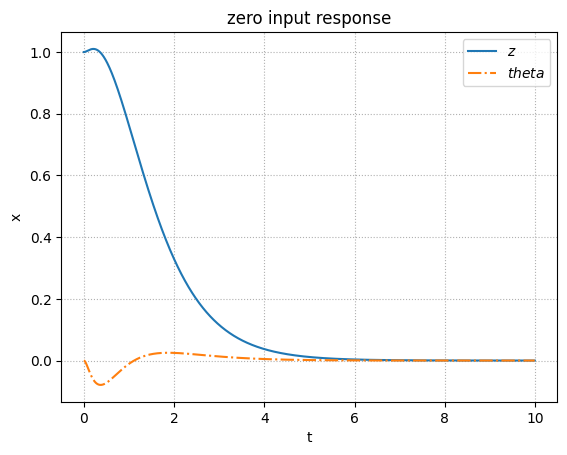

In [22]:
# 初期値応答の描画
fig, ax = plt.subplots()
ax.plot(t, x[:, 0], label = '$z$')
ax.plot(t, x[:, 1], ls = '-.', label = '$theta$')
# ax.plot(t, u , ls = ':', label = '$u$')      # 入力信号 u
ax.set_title('zero input response')

ax.set_xlabel('t')
ax.set_ylabel('x')
ax.grid(ls=':')
ax.legend(loc='best')
plt.show()

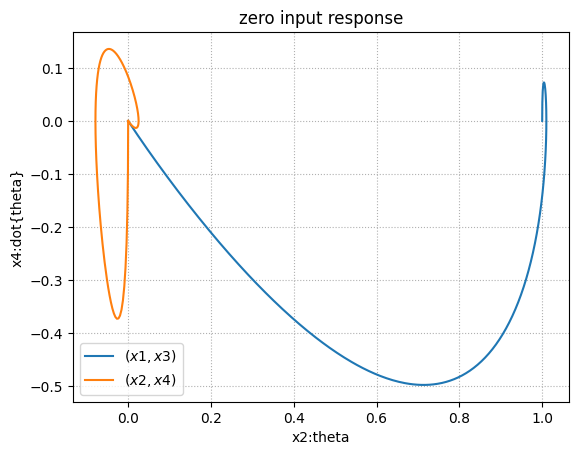

In [24]:
fig, ax = plt.subplots()
ax.plot(x[:, 0], x[:,2], label = '$(x1,x3)$')
ax.plot(x[:, 1], x[:,3], label = '$(x2,x4)$')
ax.set_title('zero input response')

ax.set_xlabel('x2:theta')
ax.set_ylabel('x4:dot{theta}')
ax.grid(ls=':')
ax.legend(loc='best')
plt.show()